- k-means
- VAT Algorithm
- Hierarchical Algorithms
- Principal Component Analysis

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib import pyplot as plt
from vat import VAT
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

## Kmeans clustering

$k$-means clustering is one of the most common unsupervised Machine Learning algorithms. The objective of $k$-means is to group _similar data points together_ and to find underlying patterns. To achieve this objective, $k$-means looks for a fixed number of $k$ clusters in a dataset. A cluster refers to the unique set of data points aggregated together according to similarities. Usually, the similarity metric is the Euclidean Distance between any two points. 

The algorithm requires the user to define a hyperparameter $k$ - the total number of centroids we want. A centroid is center of the cluster. $k$-means will then iteratively assign data points to the closest centroid.

Generally, the $k$-means algorithm has the following pseudocode:  
```python
k = number of centroids
randomly assign an initial starting point for each centroid

while True:
    for each data point:
        calculate similarity (distance) with data point and centroid
        assign data point to closest centroid
    
    for each centroid:
        recompute the centroid
        
    if no change to centroid (it has stabilized) or max iterations exceeded:
        return final centroids
    
```

In [2]:
# usually we don't specify the random points as sklearn has a built-in method of setting fixed random states
initial_clusters = np.array([[1,1], [2,1]])
data_points = np.array([[1,1], [2,1], [4,3], [5,4]])

kmean = KMeans(n_clusters=2, init=initial_clusters)
kmean.fit(data_points)

print('kmean assignments [A, B, C, D]:', kmean.labels_)
print('Final Centroid for cluster 0:')
print(kmean.cluster_centers_[0])
print('Final Centroid for cluster 1:')
print(kmean.cluster_centers_[1])

kmean assignments [A, B, C, D]: [0 0 1 1]
Final Centroid for cluster 0:
[1.5 1. ]
Final Centroid for cluster 1:
[4.5 3.5]


C:\Users\Max Ruan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


### Apply to a larger dataset

In [3]:
data = pd.read_csv('clustering.csv')
data.head()

,movie_rating,time_on_site,quantity
0,8.64,119.691050,7
1,8.53,199.034445,1
2,8.06,108.412824,1
3,7.38,141.560956,6
4,4.60,110.504130,3


In [4]:
clusters = KMeans(n_clusters=2)
clusters.fit(data)

KMeans(n_clusters=2)

In [5]:
def plot_kmeans(df, clusters):
    """
    generate a 3d plot given sklearn's kmeans implementation 
    """
    colormap = {0: 'red', 1: 'green', 2: 'blue'}
    
    fig = plt.figure(figsize=(7, 10))
    ax = plt.axes(projection="3d")
    ax.scatter(df['time_on_site'], 
               df['quantity'], 
               df['movie_rating'],
               c=[colormap.get(x) for x in clusters.labels_])
    
    ax.set_ylabel('quantity')
    ax.set_xlabel('time_on_site')
    ax.set_zlabel('movie_rating')
    ax.set_title(f"k = {len(set(clusters.labels_))}")
    
    plt.show()

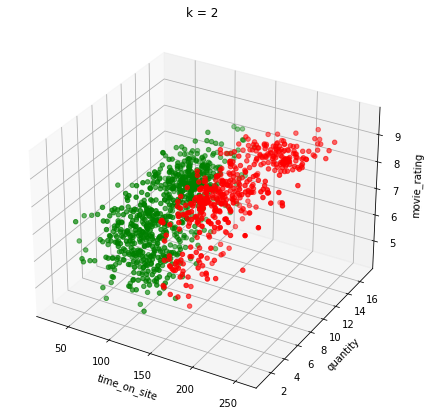

In [6]:
  plot_kmeans(data, clusters)

## Visual Assessment of clustering Tendency (VAT)

VAT is a visual method of assessing the clustering tendency of a dataset. The algorithm can reveal the number of clusters that can be found in a dataset, whilst also depicting cluster patterns. This is accomplished by ordering the matrix of pairwise object dissimilarities to create an intensity map. That is, densely colored squares along the left diagonal that indicated the clusters.

In general, the way to see the number of clusters for a given VAT algorithm is to identify the number of densely colored squares within the intensity map. The number of colored squares can be used to specify an approximate $k$ valye for the $k$-means clustering algorithm.

Firstly, we need to _normalize_ our dataset such that our clusters are on an even scale.

Remember, _normalization_ is the equivalent of _min-max scaling._

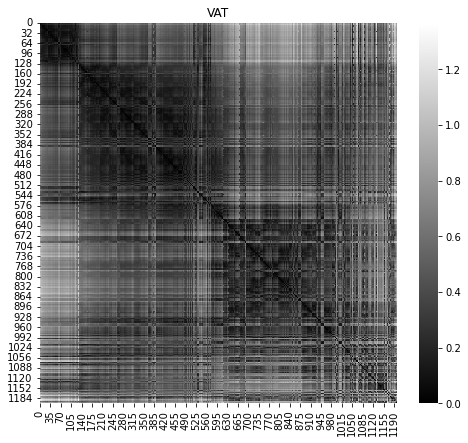

In [7]:
normalized_data = MinMaxScaler().fit_transform(data)

# Plot VAT
RV, _, I = VAT(normalized_data) # I are the reordered indices

plt.figure(figsize=(8, 7))
sns.heatmap(RV, cmap='gray')
plt.title("VAT")

plt.show()

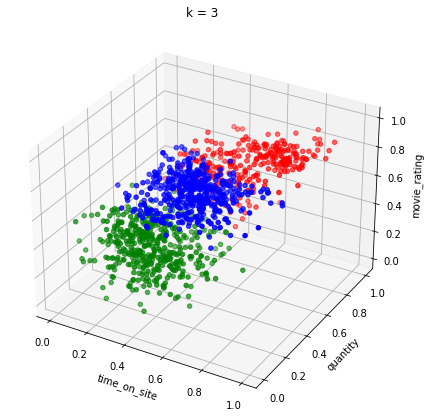

In [8]:
normalized_data = pd.DataFrame(normalized_data, columns=data.columns)
clusters = KMeans(n_clusters=3).fit(normalized_data)
plot_kmeans(normalized_data, clusters)

## Elbow Method
Beside VAT, we can also use the Elbow Method to determine the optimal number of cluster(s). 

The elbow methods requires the user to run the $k$-means clustering on the dataset for a range of $k$:
```
for k in range(...):
    perform k-means clustering
    calculate average distance from every centroid to every point
    
plot these points to find the where the average distance from the centroid falls (known as the elbow)
```

Let's use the Elbow Method to determine the optimal number of cluster(s).

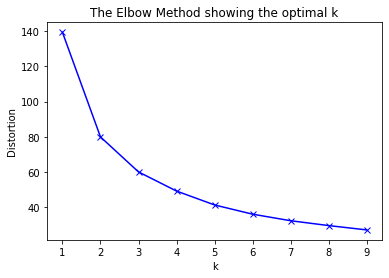

In [9]:
distortions = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_data)
    distortions.append(kmeans.inertia_) # Question: What does kmeans.inertia_ return? 
    
plt.plot(k_range, distortions, 'bx-')

plt.title('The Elbow Method showing the optimal k')
plt.xlabel('k')
plt.ylabel('Distortion')

plt.show()

## Hierarchical Clustering (HC)

Hierarchical Clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for HC fall under two types:
- Agglomerative: This is a "bottom-up" approach. Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- Divisive: This is a "top-down" approach. All observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

We will be covering ***Agglomerative Clustering*** in this workshop. 

The pseudocode of Agglomerative Clustering is as follows:
```python
compute proximity matrix (distance between each point to every other point)
let each data point be its own cluster

while True:
    merge the two closest cluster
    update proximity matrix
    
    if single cluster remains:
        break
```

To merge the two closest clusters, it is necessary to determine _how_ the distance is computed. For example, it can be computed between:
- the two most similar parts of a cluster (single-linkage);
- the two least similar bits of a cluster (complete-linkage);
- the center of the clusters (mean or average-linkage);
- or some other criterion. 

The output of a hierarchical clustering technique can be visualized using a **Dendrogram**. A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

We will demostrate single-linkage HC with a sample of the dataset

In [10]:
sample = pd.read_csv('clustering.csv').sample(5, random_state=26).reset_index(drop=True)
sample

,movie_rating,time_on_site,quantity
0,8.57,105.461032,10
1,7.15,95.991941,3
2,7.73,160.992288,4
3,8.16,139.504768,6
4,7.63,129.079253,7


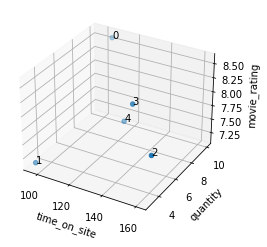

In [11]:
# Visualise the 5 data point
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(sample['time_on_site'], 
           sample['quantity'], 
           sample['movie_rating'])
ax.set_xlabel('time_on_site')
ax.set_ylabel('quantity')
ax.set_zlabel('movie_rating')

for i in range(5):
    ax.text(sample['time_on_site'][i], 
           sample['quantity'][i], 
           sample['movie_rating'][i], 
           i)
plt.show()

### Step 1: Calculate pairwise distance matrix

In [12]:
pd.DataFrame(squareform(pdist(sample))).round().astype(int)

,0,1,2,3,4
0,0,12,56,34,24
1,12,0,65,44,33
2,56,65,0,22,32
3,34,44,22,0,10
4,24,33,32,10,0


### Step 2: Iteratively merging data points

<u>Iteration 1:</u> Merge 3 & 4

|       | 0  | 1  | 2  | (3+4) |
|-------|----|----|----|-------|
| 0     | 0  | 12 | 56 | 24    |
| 1     | 12 | 0  | 65 | 33    |
| 2     | 56 | 65 | 0  | 22    |
| (3+4) | 24 | 33 | 22 | 0     |

<u>Iteration 2:</u> Merge 0 & 1

|       | (0+1) | 2  | (3+4) |
|-------|-------|----|-------|
| (0+1) | 0     | 56 | 24    |
| 2     | 56    | 0  | 22    |
| (3+4) | 24    | 22 | 0     |

<u>Iteration 3:</u> Merge 2 & (3+4)

|           | (0+1) | (2+(3+4)) |
|-----------|-------|-----------|
| (0+1)     | 0     | 24        |
| (2+(3+4)) | 24    | 0         |

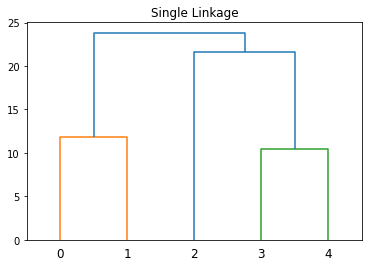

In [13]:
D = pdist(sample)
hc = linkage(sample, 'single')
dendrogram(hc, labels=sample.index)
plt.title('Single Linkage')
plt.show()

## Principle Component Analysis (PCA)
- PCA is used to transform high-dimensional data (i.e many features) into a lower-dimensional representation (i.e fewer features).
- It is especially useful for visualization and to improve computational efficiency by removing outliers or noisy data.
- PCA discards dimensions (i.e features) that tell us very little about the data.
- Once the features are discarded, we will be left with a smaller coordinate system (usually 2D axes).
- The smaller coordinate system will *encapsulate* most of the **variance** in the dataset.
- In other words, dimensions that do not have much variation in the data or holds little information will be discarded.

In [14]:
pca_data = pd.read_csv('pca.csv')
pca_data

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,-0.734813,-2.834815,-4.554009,-7.444389,6.363215,-0.166032,-1.407411,2.635098,-0.598159,7.184899,...,-8.366917,4.076429,2.664759,1.300397,0.855186,0.722187,1.303414,-0.304663,5.604633,-5.013702
1,-4.402090,-0.279574,-4.174069,-2.223990,-7.865856,-3.017668,2.705414,-0.615524,3.170800,1.383366,...,3.120900,-4.567987,-15.249835,-0.878003,0.666230,-1.849594,4.501257,-4.503171,-2.087741,-12.395254
2,-0.795630,-3.360031,1.116885,-3.039926,0.129944,-0.230940,1.106633,-0.815621,2.950032,5.912564,...,2.925407,-0.851214,-1.407044,6.680735,-1.208256,3.176663,-3.260872,-1.297405,-0.740994,0.688457
3,-2.420614,-0.874134,0.395809,3.130045,1.655578,1.146261,-1.834100,-0.057324,7.497362,-0.827915,...,1.044861,1.952787,6.812413,-4.642526,0.153182,4.706067,3.194874,0.829948,1.261124,12.231877
4,-5.146652,-0.270930,-3.014745,0.503729,-0.645226,0.759290,0.088985,6.405849,2.203890,3.248916,...,4.250417,-5.803834,-14.495750,-0.623166,-2.141602,3.933480,-8.434774,-0.897335,-0.492823,-14.220943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.419667,-2.903670,-2.863183,0.526027,7.091853,-4.264179,-1.812298,3.110307,-1.805625,0.511780,...,4.604490,2.037668,-15.312761,0.954180,1.202037,1.365958,-0.382619,0.588860,-1.272311,-16.861577
196,1.587944,-4.762594,0.482682,-0.064567,-0.436291,-2.491316,0.369542,3.178175,-0.318707,-0.952703,...,-5.102550,1.955758,4.808537,-0.893015,-6.573304,-1.462796,-1.694163,0.165401,-4.904745,-4.899586
197,-0.446887,-1.805106,4.493611,1.211150,0.005324,-6.185108,-0.339644,3.407739,-0.126642,0.431080,...,-0.692909,1.807778,3.241813,2.140824,0.334501,-3.535555,1.986230,-3.298104,-2.881044,-0.936659
198,-1.383739,0.415562,5.008799,-3.538682,-12.268950,-4.549904,-1.934834,-0.397804,-3.980964,0.420956,...,4.820739,-0.532877,8.594791,5.053177,-6.994032,3.457584,3.158128,3.050920,-5.950127,4.536940


In [15]:
# conduct PCA with n=3 components (or axis)
sklearn_pca = PCA(n_components=3)
X_pca = sklearn_pca.fit_transform(pca_data)

The attribute of interest (and something you should remember) is `explained_variance_ratio_`. 

This is to see how much of the variance is being explained by the first X components. In this case, we have 3 components.

In [16]:
explained_var = sklearn_pca.explained_variance_ratio_

print(f"Variance explained by each PC: {explained_var}")   
print(f"Total variance explained: {explained_var.sum():.4f}")

Variance explained by each PC: [0.26022308 0.21027171 0.14114954]
Total variance explained: 0.6116


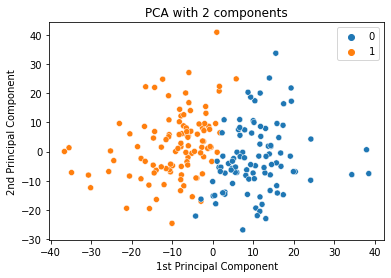

In [17]:
# Perform 2-means clustering
clusters = KMeans(n_clusters=2).fit(pca_data)

# Visualise the first 2 PCs
sns.scatterplot(x=X_pca[:,0], 
                y=X_pca[:,1],
                hue=clusters.labels_)
plt.title("PCA with 2 components")
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

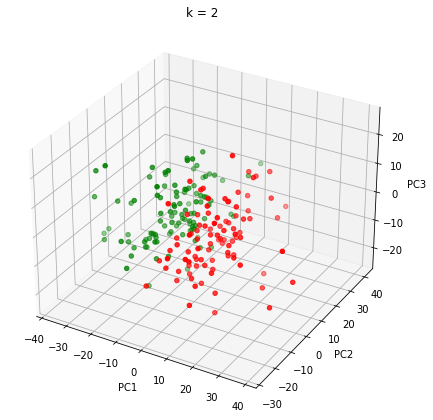

In [18]:
# Perform 2-means clustering
clusters = KMeans(n_clusters=2).fit(pca_data)

colormap = {0: 'red', 1: 'green', 2: 'blue'}
    
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection="3d")
ax.scatter(X_pca[:,0], 
           X_pca[:,1], 
           X_pca[:,2],
           c=[colormap.get(x) for x in clusters.labels_])

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_zlabel('PC3')
ax.set_title(f"k = {len(set(clusters.labels_))}")

plt.show()